# Loan Payback Prediction - Advanced Ensemble (Stacking + Optuna)

## Goal
Predict the probability that a borrower will pay back their loan using a Stacking Ensemble of XGBoost, Logistic Regression, and MLP (Neural Network). We will use Optuna for Bayesian Hyperparameter Optimization and add interaction features.

## Steps
1.  Data Loading
2.  Advanced Feature Engineering
3.  Hyperparameter Tuning (Optuna)
4.  Ensemble Modeling (StackingClassifier)
5.  Model Evaluation (Stratified K-Fold CV)
6.  Submission Generation

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

## 1. Data Loading

In [11]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (593994, 13)
Test shape: (254569, 12)


## 2. Advanced Feature Engineering

In [12]:
# Combine for consistent encoding
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['loan_paid_back'] = np.nan

full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# --- New Interaction Features ---
# 1. Loan to Income Ratio
full_df['loan_to_income'] = full_df['loan_amount'] / (full_df['annual_income'] + 1) # +1 to avoid div by zero

# 2. Disposable Income (Approximate)
# debt_to_income_ratio is usually a percentage (e.g., 20.5). If it's 0-100, we divide by 100.
# Assuming it's already a ratio or percentage, let's check range later. For now assuming it's a ratio 0-1 or percentage.
# Let's assume it's a value where higher means more debt.
full_df['disposable_income'] = full_df['annual_income'] * (1 - full_df['debt_to_income_ratio'] / 100) 

# 1. Log Transformation for skewed features (including new ones if skewed)
skewed_features = ['annual_income', 'loan_amount', 'debt_to_income_ratio', 'loan_to_income', 'disposable_income']
# Handle negative values for log (if any)
for col in skewed_features:
    full_df[col] = np.log1p(np.maximum(full_df[col], 0))

# 2. Ordinal Encoding for grade_subgrade
grades = sorted(full_df['grade_subgrade'].unique())
grade_map = {grade: i for i, grade in enumerate(grades)}
full_df['grade_subgrade_encoded'] = full_df['grade_subgrade'].map(grade_map)

# 3. One-Hot Encoding for other categoricals
categorical_cols = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']
full_df = pd.get_dummies(full_df, columns=categorical_cols, drop_first=True)

# Drop original grade_subgrade and id
full_df.drop(['grade_subgrade', 'id'], axis=1, inplace=True)

# Split back
train_processed = full_df[full_df['is_train'] == 1].drop(['is_train'], axis=1)
test_processed = full_df[full_df['is_train'] == 0].drop(['is_train', 'loan_paid_back'], axis=1)

X = train_processed.drop('loan_paid_back', axis=1)
y = train_processed['loan_paid_back']
X_test = test_processed

print(f"Processed Train shape: {X.shape}")
print(f"Processed Test shape: {X_test.shape}")

Processed Train shape: (593994, 28)
Processed Test shape: (254569, 28)


## 3. Hyperparameter Tuning (Optuna)

In [19]:
# Use a smaller subset for tuning to save time
X_tune, _, y_tune, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=42)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 1.0),
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'hist',
        'eval_metric': 'auc'
    }
    
    model = xgb.XGBClassifier(**params)
    score = cross_val_score(model, X_tune, y_tune, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return score

print("Tuning XGBoost with Optuna...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30) # 10 trials for speed
print(f"Best XGB Params: {study_xgb.best_params}")
best_xgb_params = study_xgb.best_params
best_xgb_params['n_jobs'] = -1
best_xgb_params['random_state'] = 42
best_xgb_params['tree_method'] = 'hist'
best_xgb_params['eval_metric'] = 'auc'

[I 2025-11-23 15:30:07,282] A new study created in memory with name: no-name-4baeb9bc-58da-4927-be28-c50302f82e5b


Tuning XGBoost with Optuna...


[I 2025-11-23 15:30:27,962] Trial 0 finished with value: 0.9045741159324842 and parameters: {'n_estimators': 2360, 'learning_rate': 0.08074885149375895, 'max_depth': 5, 'subsample': 0.7831088489711543, 'colsample_bytree': 0.9392438724509118, 'scale_pos_weight': 0.7560406173840005}. Best is trial 0 with value: 0.9045741159324842.
[I 2025-11-23 15:30:35,481] Trial 1 finished with value: 0.9163112933309076 and parameters: {'n_estimators': 851, 'learning_rate': 0.07789553974868114, 'max_depth': 3, 'subsample': 0.9760944958110335, 'colsample_bytree': 0.9319958147742511, 'scale_pos_weight': 0.6583578241341821}. Best is trial 1 with value: 0.9163112933309076.
[I 2025-11-23 15:30:49,696] Trial 2 finished with value: 0.9078028770101269 and parameters: {'n_estimators': 1728, 'learning_rate': 0.06752072557037471, 'max_depth': 5, 'subsample': 0.6260997499140724, 'colsample_bytree': 0.6184819269990505, 'scale_pos_weight': 0.5750732996939077}. Best is trial 1 with value: 0.9163112933309076.
[I 2025-

Best XGB Params: {'n_estimators': 580, 'learning_rate': 0.026721696221596786, 'max_depth': 4, 'subsample': 0.7440053065744467, 'colsample_bytree': 0.9005932942177117, 'scale_pos_weight': 0.815855735059234}


In [14]:
def objective_lr(trial):
    C = trial.suggest_float('C', 0.001, 10, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(C=C, penalty=penalty, solver='saga', max_iter=500, random_state=42))
    ])
    
    score = cross_val_score(pipeline, X_tune, y_tune, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return score

print("\nTuning Logistic Regression with Optuna...")
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=30)
print(f"Best LR Params: {study_lr.best_params}")
best_lr_params = study_lr.best_params

[I 2025-11-23 14:51:30,427] A new study created in memory with name: no-name-cb5a6d30-3fe9-4d0f-970e-ac4dc5edec14



Tuning Logistic Regression with Optuna...


[I 2025-11-23 14:51:31,488] Trial 0 finished with value: 0.9121209636160964 and parameters: {'C': 1.490446967687481, 'penalty': 'l1'}. Best is trial 0 with value: 0.9121209636160964.
[I 2025-11-23 14:51:32,476] Trial 1 finished with value: 0.9112051933643759 and parameters: {'C': 0.003192426926704433, 'penalty': 'l1'}. Best is trial 0 with value: 0.9121209636160964.
[I 2025-11-23 14:51:33,658] Trial 2 finished with value: 0.9121325585340033 and parameters: {'C': 0.03768376677825955, 'penalty': 'l2'}. Best is trial 2 with value: 0.9121325585340033.
[I 2025-11-23 14:51:34,587] Trial 3 finished with value: 0.9121285868478065 and parameters: {'C': 0.0658719248501003, 'penalty': 'l2'}. Best is trial 2 with value: 0.9121325585340033.
[I 2025-11-23 14:51:35,313] Trial 4 finished with value: 0.9121329695543814 and parameters: {'C': 0.0454351117477826, 'penalty': 'l2'}. Best is trial 4 with value: 0.9121329695543814.
[I 2025-11-23 14:51:36,015] Trial 5 finished with value: 0.9121190149030243 an

Best LR Params: {'C': 0.018197080840653312, 'penalty': 'l1'}


In [15]:
def objective_mlp(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(64, 32, 16), (32, 32, 32), (128, 64, 32, 16), (64, 64, 64, 64), (128, 64, 32, 16, 8), (64, 64, 64, 64, 64)])
    alpha = trial.suggest_float('alpha', 0.0001, 0.01, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 0.001, 0.01, log=True)
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=200,
            random_state=42,
            early_stopping=True
        ))
    ])
    
    score = cross_val_score(pipeline, X_tune, y_tune, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return score

print("\nTuning MLP with Optuna...")
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=30) # MLP is slower
print(f"Best MLP Params: {study_mlp.best_params}")
best_mlp_params = study_mlp.best_params

[I 2025-11-23 14:51:59,330] A new study created in memory with name: no-name-e04a0feb-c906-4089-b38a-5371ae034a1d



Tuning MLP with Optuna...


[I 2025-11-23 14:52:09,066] Trial 0 finished with value: 0.9097793845160128 and parameters: {'hidden_layer_sizes': (128, 64, 32, 16), 'alpha': 0.004425502516406032, 'learning_rate_init': 0.006538884415251696}. Best is trial 0 with value: 0.9097793845160128.
[I 2025-11-23 14:52:19,765] Trial 1 finished with value: 0.9094517179403315 and parameters: {'hidden_layer_sizes': (64, 64, 64, 64), 'alpha': 0.0005004809632023233, 'learning_rate_init': 0.001066903891803515}. Best is trial 0 with value: 0.9097793845160128.
[I 2025-11-23 14:52:28,930] Trial 2 finished with value: 0.9094734629216976 and parameters: {'hidden_layer_sizes': (64, 64, 64, 64), 'alpha': 0.00180452549253326, 'learning_rate_init': 0.009112742151836484}. Best is trial 0 with value: 0.9097793845160128.
[I 2025-11-23 14:52:33,806] Trial 3 finished with value: 0.9087574411823334 and parameters: {'hidden_layer_sizes': (64, 32, 16), 'alpha': 0.007158986540589871, 'learning_rate_init': 0.0015889362730969183}. Best is trial 0 with v

Best MLP Params: {'hidden_layer_sizes': (64, 64, 64, 64, 64), 'alpha': 0.0004462891172920905, 'learning_rate_init': 0.004493996667835146}


## 4. Ensemble Modeling (StackingClassifier)

In [20]:
# Create Base Estimators
xgb_clf = xgb.XGBClassifier(**best_xgb_params)

lr_clf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        C=best_lr_params['C'], 
        penalty=best_lr_params['penalty'], 
        solver='saga', 
        max_iter=1000, 
        random_state=42
    ))
])

mlp_clf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=best_mlp_params['hidden_layer_sizes'],
        alpha=best_mlp_params['alpha'],
        learning_rate_init=best_mlp_params['learning_rate_init'],
        max_iter=500,
        random_state=42,
        early_stopping=True
    ))
])

# Stacking Classifier
# Meta-learner is usually a simple Logistic Regression
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('lr', lr_clf),
        ('mlp', mlp_clf)
    ],
    final_estimator=LogisticRegression(),
    cv=3, # CV for stacking predictions
    n_jobs=-1
)

## 5. Model Evaluation (Stratified K-Fold CV)

In [21]:
FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

print("Evaluating Stacking Ensemble (this may take a while)...")
cv_scores = cross_val_score(stacking_clf, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"Stacking Ensemble CV ROC AUC Scores: {cv_scores}")
print(f"Average Stacking Ensemble CV ROC AUC: {np.mean(cv_scores):.5f} +/- {np.std(cv_scores):.5f}")

Evaluating Stacking Ensemble (this may take a while)...
Stacking Ensemble CV ROC AUC Scores: [0.91907209 0.91818445 0.91668514 0.91786883 0.91749602]
Average Stacking Ensemble CV ROC AUC: 0.91786 +/- 0.00079


Generating predictions for the ROC Curve...


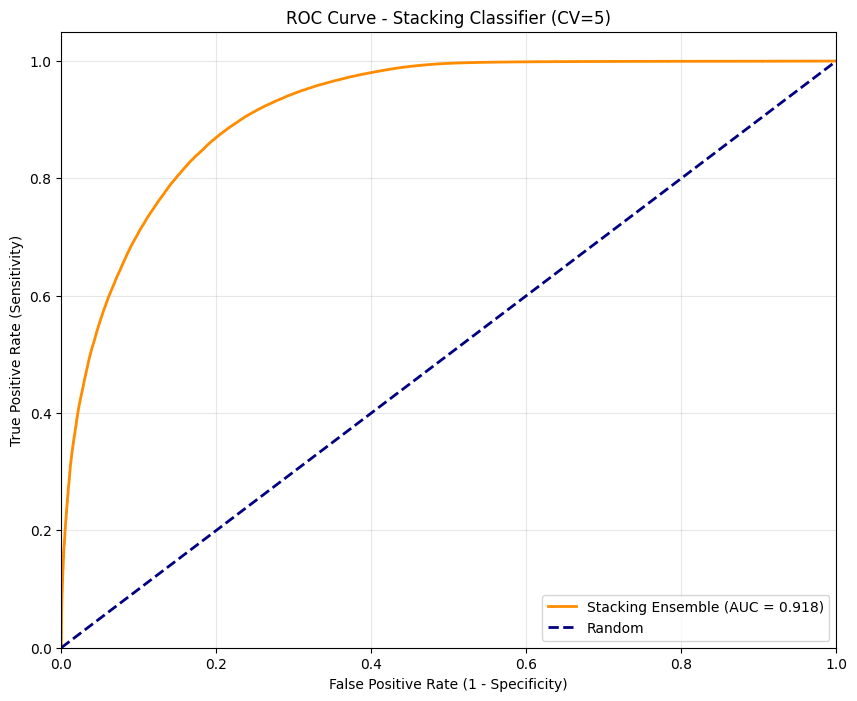

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

# ... (Your previous code for defining models and stacking_clf here) ...

print("Generating predictions for the ROC Curve...")

# IMPORTANT:
# cross_val_score only returns the score.
# For the ROC curve, we need the probabilities of each prediction.
# We use method='predict_proba' to get the probability of the positive class (index 1)
y_probas = cross_val_predict(
    stacking_clf,
    X,
    y,
    cv=skf,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# Calculate FPR, TPR, and AUC
fpr, tpr, thresholds = roc_curve(y, y_probas)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacking Ensemble (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title(f'ROC Curve - Stacking Classifier (CV={FOLDS})')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Save the image
plt.savefig('roc_curve_stacking.png', dpi=300, bbox_inches='tight')
plt.show()

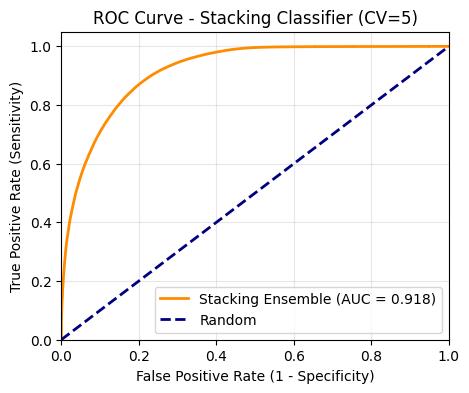

In [27]:
# Plot the ROC Curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacking Ensemble (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title(f'ROC Curve - Stacking Classifier (CV={FOLDS})')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Save the image
plt.savefig('roc_curve_stacking.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Submission Generation

In [22]:
# Fit on full training data
print("Retraining stacking ensemble on full data...")
stacking_clf.fit(X, y)

# Predict on test set
test_preds = stacking_clf.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'id': test_df['id'],
    'loan_paid_back': test_preds
})

submission.to_csv('submission_stacking.csv', index=False)
print("Submission saved to submission_stacking.csv")
submission.head()

Retraining stacking ensemble on full data...
Submission saved to submission_stacking.csv


,id,loan_paid_back
0,593994,0.936801
1,593995,0.963264
2,593996,0.355485
3,593997,0.951510
4,593998,0.954195


In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

# ... (Your previous code for defining models and stacking_clf here) ...

print("Generating predictions for the ROC Curve...")

# IMPORTANT:
# cross_val_score only returns the score.
# For the ROC curve, we need the probabilities of each prediction.
# We use method='predict_proba' to get the probability of the positive class (index 1)
y_probas = cross_val_predict(
    stacking_clf,
    X,
    y,
    cv=skf,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# Calculate FPR, TPR, and AUC
fpr, tpr, thresholds = roc_curve(y, y_probas)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacking Ensemble (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title(f'ROC Curve - Stacking Classifier (CV={FOLDS})')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Save the image
plt.savefig('roc_curve_stacking.png', dpi=300, bbox_inches='tight')
plt.show()

Gerando predições para a Curva ROC...


KeyboardInterrupt: 